### Binary cross entropy loss
\begin{equation*}
L(\theta) = - \frac{1}{n} \sum_{i=1}^n [y_i log(p_i) + (1 - y_i) log(1 - p_i)]
\end{equation*}

- Discriminator final probability is 1 => REAL IMAGE
- Discriminator final probability is 0 => FAKE IMAGE

Log values:
- Log(1) => Loss would be 0
- Log(0+) => Loss would be to - ∞

### Generator:

Maximize D(G(z))


### Discriminator:

Maximize D(x) AND minimize D(G(z))

## Some tricks to train GANs
### https://github.com/soumith/ganhacks

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
def normalize(vector, a, b):
    assert(a < b)
    max_val = np.max(vector)
    min_val = np.min(vector)

    result = (b - a) * ( (vector - min_val) / (max_val - min_val) ) + a

    return result

(X_train, Y_train), _ = mnist.load_data()

# Expand to have 1 channel (grey images)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

# Print max and min and normalize
print("MAX : " + str(X_train.max()) + " and MIN: " + str(X_train.min()))
X_train = normalize(X_train, -1, 1)
print("Normalized MAX : " + str(X_train.max()) + " and MIN: " + str(X_train.min()))

assert(X_train.shape[1] == X_train.shape[2])

(60000, 28, 28, 1)
MAX : 255 and MIN: 0
Normalized MAX : 1.0 and MIN: -1.0


In [3]:
# Parameters network and training
epochs = 1000
batchSize = 32
lr = 0.0002
Z_dim = 100
mu, sigma = 0, 1

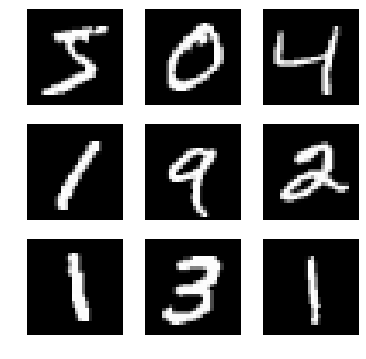

In [4]:
# Show some samples
fig = plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(X_train[i]), cmap='gray')
    plt.axis('off')

In [ ]:
def upConv2DLayer(inputTensor, numFilters, size=5, stride=2, name=None, bn=True, activation=True):
    #initializer = tf.random_normal_initializer(0, 0.02)
    #tf.truncated_normal_initializer(stddev=0.1)
    
    output = tf.keras.layers.Conv2DTranspose(numFilters, # Number of output channels
                                            kernel_size=(size,size), # Size of each filter
                                            strides=(stride,stride), 
                                            padding="same", 
                                            activation=None,
                                            use_bias=False,
                                            name=name)(inputTensor)
    print(output)
    if bn:
        output = tf.keras.layers.BatchNormalization()(output)
        print(output)
        
    if activation:
        output = tf.keras.layers.LeakyReLU()(output)
        print(output)
         
    return output

In [ ]:
# Sample noise for generator
def sample_Z(batch_size, img_size, mu, sigma):
    return np.random.normal(mu, sigma, size=[batch_size, img_size])
    #return np.random.uniform(-1., 1., size=[batch_size, img_size])

    
'''# Generator network
def generator(z, reuse=False):
    
    with tf.variable_scope("generator", reuse=reuse):
        print(z)
        fc1 = tf.keras.layers.Dense(7*7*256, use_bias=False)(z)
        print(fc1)
        bn1 = tf.keras.layers.BatchNormalization()(fc1)
        print(bn1)
        relu1 = tf.keras.layers.LeakyReLU()(bn1)
        print(relu1)
        
        reshaped = tf.reshape(relu1, shape=[-1, 7, 7, 256])
        print(reshaped)

        upConv1 = upConv2DLayer(reshaped, 128, 5, 1, "upConv1")
        upConv2 = upConv2DLayer(upConv1, 64, 5, 2, "upConv2")
        upConv3 = upConv2DLayer(upConv2, 1, 5, 2, "upConv3", bn=False, activation=False)
        
        output = tf.nn.tanh(upConv3)
        print(output)
        
        return output
    
# Discriminator
def discriminator(x, reuse=False, dropout=0.3):
    
    with tf.variable_scope("discriminator", reuse=reuse):
        conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
        relu1 = tf.keras.layers.LeakyReLU()(conv1)
        drop1 = tf.keras.layers.Dropout(dropout)(relu1)
        
        conv2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(drop1)
        relu2 = tf.keras.layers.LeakyReLU()(conv2)
        drop2 = tf.keras.layers.Dropout(dropout)(relu2)

        flattened = tf.keras.layers.Flatten()(drop2)
        output = tf.keras.layers.Dense(1)(flattened)
        output = tf.nn.sigmoid(output)
    if not reuse:
        print(x)
        print(conv1)
        print(relu1)
        print(drop1)
        print(conv2)
        print(relu2)
        print(drop2)
        print(flattened)
        print(output)
        
    return output'''

'# Generator network\ndef generator(z, reuse=False):\n    \n    with tf.variable_scope("generator", reuse=reuse):\n        print(z)\n        fc1 = tf.keras.layers.Dense(7*7*256, use_bias=False)(z)\n        print(fc1)\n        bn1 = tf.keras.layers.BatchNormalization()(fc1)\n        print(bn1)\n        relu1 = tf.keras.layers.LeakyReLU()(bn1)\n        print(relu1)\n        \n        reshaped = tf.reshape(relu1, shape=[-1, 7, 7, 256])\n        print(reshaped)\n\n        upConv1 = upConv2DLayer(reshaped, 128, 5, 1, "upConv1")\n        upConv2 = upConv2DLayer(upConv1, 64, 5, 2, "upConv2")\n        upConv3 = upConv2DLayer(upConv2, 1, 5, 2, "upConv3", bn=False, activation=False)\n        \n        output = tf.nn.tanh(upConv3)\n        print(output)\n        \n        return output\n    \n# Discriminator\ndef discriminator(x, reuse=False, dropout=0.3):\n    \n    with tf.variable_scope("discriminator", reuse=reuse):\n        conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding=\

In [ ]:
def generator(z, reuse=False):
    
    with tf.variable_scope("generator", reuse=reuse):        
        fc1 = tf.layers.dense(inputs=z, units=256, activation=tf.nn.leaky_relu)
        fc2 = tf.layers.dense(inputs=fc1, units=784, activation=None)
        logits = tf.nn.tanh(fc2)
        output = tf.reshape(logits, shape=[-1, 28, 28, 1])
        
        print("Generator:")
        print(z)
        print(fc1)
        print(fc2)
        print(logits)
        print(output)
        
    return output


def discriminator(x, reuse=False):
    
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.layers.Flatten()(x)
        fc1 = tf.layers.dense(inputs=x, units=256, activation=tf.nn.leaky_relu)
        fc2 = tf.layers.dense(inputs=fc1, units=1, activation=None)
        prob = tf.nn.sigmoid(fc2)
        
        if not reuse:
            print("\nDiscriminator:")
            print(x)
            print(fc1)
            print(fc2)
            print(prob)
        
    return prob

In [ ]:
tf.reset_default_graph()

# Generator noise input
Z = tf.placeholder(tf.float32, shape=[None, Z_dim], name='Z')

# Discriminator input
X = tf.placeholder(tf.float32, shape=[None, X_train.shape[1], X_train.shape[2], X_train.shape[3]], name='X')

# Networks
G_z = generator(Z)

D_fake = discriminator(G_z, reuse=False)
D_real = discriminator(X, reuse=True)

# Loss
D_loss = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_fake))
G_loss = tf.reduce_mean(tf.log(D_fake))

# Optimizer
D_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
G_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')
print(G_var_list)
print(D_var_list)

D_optimizer = tf.train.AdamOptimizer(lr, beta1 = 0.5).minimize(-D_loss, var_list=D_var_list)
G_optimizer = tf.train.AdamOptimizer(lr, beta1 = 0.5).minimize(-G_loss, var_list=G_var_list)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Generator:
Tensor("Z:0", shape=(?, 100), dtype=float32)
Tensor("generator/dense/LeakyRelu:0", shape=(?, 256), dtype=float32)
Tensor("generator/dense_1/BiasAdd:0", shape=(?, 784), dtype=float32)
Tensor("generator/Tanh:0", shape=(?, 784), dtype=float32)
Tensor("generator/Reshape:0", shape=(?, 28, 28, 1), dtype=float32)

Discriminator:
Tensor("discriminator/flatten/Reshape:0", shape=(?, 784), dtype=float32)
Tensor("discriminator/dense/LeakyRelu:0", shape=(?, 256), dtype=float32)
Tensor("discriminator/dense_1/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("discriminator/Sigmoid:0", shape=(?, 1), dtype=float32)
[<tf.Variable 'generator/dense/kernel:0' shape=(100, 256) dtype=float32_ref>, <tf.Variable 'generator/dense/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'generator/dense_1/kernel:0' shape=(256, 784) dtype=float32_ref>, <tf.Variable 'generator/de

In [ ]:
'''def discriminatorLoss(dis_real, dis_fake, smoothing=1.0):

    dis_real_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_real, labels=tf.ones_like(dis_real) * smoothing)
    dis_fake_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake, labels=tf.zeros_like(dis_fake))
    
    dis_loss_real = tf.reduce_mean(dis_real_ce)
    dis_loss_fake = tf.reduce_mean(dis_fake_ce)
    
    return tf.reduce_mean(dis_real_ce + dis_fake_ce)


def generatorLoss(dis_fake):
    gen_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake, labels=tf.ones_like(dis_fake))

    return tf.reduce_mean(gen_ce)
    
D_loss = discriminatorLoss(D_real, D_fake)
G_loss = generatorLoss(D_fake)

D_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
D_optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(D_loss, var_list=D_var)

G_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')
G_optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(G_loss, var_list=G_var)'''

"def discriminatorLoss(dis_real, dis_fake, smoothing=1.0):\n\n    dis_real_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_real, labels=tf.ones_like(dis_real) * smoothing)\n    dis_fake_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake, labels=tf.zeros_like(dis_fake))\n    \n    dis_loss_real = tf.reduce_mean(dis_real_ce)\n    dis_loss_fake = tf.reduce_mean(dis_fake_ce)\n    \n    return tf.reduce_mean(dis_real_ce + dis_fake_ce)\n\n\ndef generatorLoss(dis_fake):\n    gen_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake, labels=tf.ones_like(dis_fake))\n\n    return tf.reduce_mean(gen_ce)\n    \nD_loss = discriminatorLoss(D_real, D_fake)\nG_loss = generatorLoss(D_fake)\n\nD_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')\nD_optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(D_loss, var_list=D_var)\n\nG_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')\nG_optimizer = tf.train.AdamOptimizer(lear

In [ ]:
def saveImages(images, globalStep, samples=9):    
    size = np.sqrt(samples)
    fig = plt.figure(figsize=(15, 15))

    for i in range(np.minimum(samples, len(images))):
        plt.subplot(size, size, i+1)
        plt.imshow(np.squeeze(images[i]), cmap='gray')
        plt.axis('off')

    plt.savefig('./images/image_' + str(globalStep) + '.png')
    #plt.show()
    plt.close(fig)

## Training of the generator and discriminator network

In [ ]:
tf.summary.scalar('D_loss', D_loss)
tf.summary.scalar('G_loss', G_loss)

# MERGE SUMMARIES - Merge all summaries into a single op
merged_summ = tf.summary.merge_all()

# VISUALIZE => tensorboard --logdir=.
summaries_dir = "./checkpoints"

In [ ]:
indices = list(range(len(X_train)))

with tf.Session() as sess:

    # Run the initializer
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    
    summary_writer = tf.summary.FileWriter(summaries_dir, graph=tf.get_default_graph())
    
    # Epochs
    globalStep = 1
    for i in range(epochs):
        
        # Shuffle dataset every epoch
        print("Epoch " + str(i))
        np.random.shuffle(indices)
        X_train = X_train[indices]
        
        for j in range(0, len(X_train), batchSize):
            
            # Sample noise
            noise = sample_Z(len(X_train[j:j+batchSize]), Z_dim, mu, sigma)
            
            _ = sess.run(D_optimizer, feed_dict={ X: X_train[j:j+batchSize], 
                                                  Z: noise })

            _, summary = sess.run([G_optimizer, merged_summ], feed_dict={ X: X_train[j:j+batchSize],
                                                                          Z: noise })
            summary_writer.add_summary(summary, globalStep)
            
            globalStep += 1
        
        # Check results every epoch
        save_path = saver.save(sess, "./checkpoints/model.ckpt")                
        output = sess.run(G_z, feed_dict={ Z: noise })
        saveImages(output, globalStep)

Epoch 0
Epoch 1
Epoch 2
